In [80]:
## Import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV, KFold

In [85]:
## Load dataset and drop unusefull columns
X_full = pd.read_csv('classes_dataset.csv', dtype={col: np.float32 for col in ['lcc', 'lcom*']})
X_full.shape

(50930, 15)

In [86]:
## Initial data treatment
X_full = X_full.drop(['lcc'], axis=1)
X_full = X_full.drop(['refusedBequest'], axis=1)
X_full = X_full.dropna()
X_full.shape

(49325, 13)

In [87]:
## Show dataframe header
X_full.head()

,Unnamed: 0,dit,fanin,fanout,lcom*,loc,noc,rfc,innerClassesQty,totalFieldsQty,totalMethodsQty,wmc,godClass
0,0,4,1,6,0.592593,39,0,12,0,3,9,10,0
1,1,4,2,7,0.000000,18,0,6,0,0,4,6,0
2,2,1,0,0,1.000000,56,0,0,3,4,4,4,0
3,3,1,1,0,0.000000,4,0,0,0,0,2,2,0
4,4,3,3,5,0.000000,16,0,7,0,0,4,4,0


In [88]:
## Function to show boxplot
def plot_boxplot(df):
    df.boxplot()
    plt.grid(False)
    plt.show()

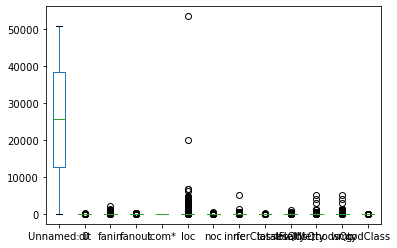

In [89]:
plot_boxplot(X_full)

In [90]:
## Function to return outliers
def outliers(df, ft):
    
    ## first quartile
    Q1 = df[ft].quantile(0.25)
    
    ## third quartile
    Q3 = df[ft].quantile(0.75)
    
    ## calculate interquartile range - distance between quartiles
    IQR = Q3-Q1
    
    ## calculate upper boundary
    UB = Q3 + 1.5 * IQR
    
    ## calculate lower boundary
    LB = Q1 - 1.5 * IQR
    
    ## outliers list
    index_outliers = df.index[ (df[ft] < LB) | (df[ft] > UB) ]
    
    # return indexes list
    return index_outliers

In [91]:
## Create list of outliers, by index
index_list = []
for feature in ['dit', 'fanin', 'fanout', 'lcom*', 'loc', 'noc', 'rfc', 'innerClassesQty', 'totalFieldsQty', 'totalMethodsQty', 'wmc']:
    index_list.extend(outliers(X_full, feature))

In [92]:
## Show index list size
len(index_list)

44094

In [95]:
## Split dataset in metrics and godsmell ds
X = X_full.drop(['godClass'], axis=1)
y = X_full.godClass

In [98]:
## Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=3)

In [99]:
## Show metrics dataset header
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39460 entries, 1183 to 6119
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       39460 non-null  int64  
 1   dit              39460 non-null  int64  
 2   fanin            39460 non-null  int64  
 3   fanout           39460 non-null  int64  
 4   lcom*            39460 non-null  float32
 5   loc              39460 non-null  int64  
 6   noc              39460 non-null  int64  
 7   rfc              39460 non-null  int64  
 8   innerClassesQty  39460 non-null  int64  
 9   totalFieldsQty   39460 non-null  int64  
 10  totalMethodsQty  39460 non-null  int64  
 11  wmc              39460 non-null  int64  
dtypes: float32(1), int64(11)
memory usage: 3.8 MB


In [101]:
y_train

1183     0
46352    0
6999     0
7087     0
47098    1
        ..
26634    0
49648    0
11720    0
1756     0
6119     0
Name: godClass, Length: 39460, dtype: int64

In [103]:
np.any(np.isnan(X))

False

In [104]:
## PIPELINE

In [105]:
SEED=0
decision_tree_regressor = DecisionTreeRegressor(random_state=SEED, criterion='mse')

In [106]:
pipe = Pipeline(steps=[
            ('robustscaler', RobustScaler()),
            ('regressor', decision_tree_regressor)
    ])

In [107]:
# https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
parameters = dict(
    regressor__max_depth= [2,3,5,7,9,11,13],
    regressor__min_samples_split= [32,64,128,256],
    regressor__min_samples_leaf= [32,64,128,256])

In [108]:
randomized_search = RandomizedSearchCV(pipe,
                              parameters,
                              cv = KFold(n_splits=5),
                                        n_iter=20,
                                      random_state=11)

In [109]:
# Exporta precisão? Acurácia? Etc...
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                             ('regressor',
                                              DecisionTreeRegressor(random_state=0))]),
                   n_iter=20,
                   param_distributions={'regressor__max_depth': [2, 3, 5, 7, 9,
                                                                 11, 13],
                                        'regressor__min_samples_leaf': [32, 64,
                                                                        128,
                                                                        256],
                                        'regressor__min_samples_split': [32, 64,
                                                                         128,
                                                                         256]},
                   random_state=11)

In [111]:
resultados = pd.DataFrame(randomized_search.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__min_samples_split,param_regressor__min_samples_leaf,param_regressor__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.074153,0.054549,0.006255,0.012509,64,128,2,"{'regressor__min_samples_split': 64, 'regresso...",0.579718,0.508730,0.550061,0.516714,0.526152,0.536275,0.025773,19
1,0.075259,0.011772,0.000000,0.000000,128,128,11,"{'regressor__min_samples_split': 128, 'regress...",0.647416,0.530607,0.556463,0.536338,0.595963,0.573358,0.043541,11
2,0.088152,0.008242,0.004866,0.006349,256,64,11,"{'regressor__min_samples_split': 256, 'regress...",0.697923,0.630189,0.658931,0.614860,0.624366,0.645254,0.030160,6
3,0.087504,0.007655,0.000000,0.000000,128,64,13,"{'regressor__min_samples_split': 128, 'regress...",0.708374,0.641294,0.672289,0.620521,0.640518,0.656599,0.030729,2
4,0.050003,0.006248,0.003125,0.006249,32,32,2,"{'regressor__min_samples_split': 32, 'regresso...",0.579718,0.508943,0.550061,0.516714,0.525338,0.536155,0.025794,20


In [113]:
# qual acuracia e precisao?
randomized_search.best_params_

{'regressor__min_samples_split': 32,
 'regressor__min_samples_leaf': 32,
 'regressor__max_depth': 13}

In [114]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [24]:
precision_score(y, y)

1.0

In [25]:
recall_score(y,y)

1.0

In [26]:
accuracy_score(y,y)

1.0

In [27]:
f1_score(y,y)

1.0